In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# include actual code

from functions_predetermined import functions_predetermined
from pdfansatz import pdf
from wilson_coeff import wilson_coeff
from ope_basic import ope_basic
from latobj import latobj
from gen_itd import gen_itd
from chisquare import *
from itd_fit import itd_fit

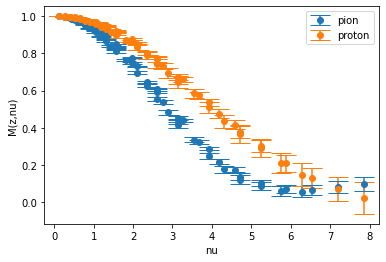

In [40]:
#################################################################################
#     Initializations    
# 
#      Important variables to play with:
#       error_scale controls the size of error in the mock data
#      "correction_coeffs" changes the amount of higher loop correction
#       set correction_coeffs = [0, 0, 0], if no corrections to NLO.
#       L_qcd controls the higher twist
#       c_latt controls (a/z)^2 correction
#################################################################################

#create lattice object
lobj = latobj(
    Lz = 48,            # lattice extent
    a_latt = 0.06,      # lattice spacing
    zmin = 1,           # smallest z for ITD
    zmax = 12,          # largesr z for ITD
    pmin = 1,           # smallest momentum for ITD
    pmax = 5)           # largest momentum for ITD

#create pion PDF object
pdf_pion = pdf(alpha = -0.45,    #small-x alpha
               beta = 1.0,       #large-x beta
               mu = 3.2,         #factorization scale
               nmom = 30,        #number of moments used in twist-2 OPE to generate ITD data
               hadname = 'pion'  # hadron name
              )
#create proton PDF object
pdf_proton = pdf(alpha = -0.25, 
                 beta = 3.0,
                 mu = 3.2,
                 nmom = 30,
                 hadname = 'proton'
                )

#create pion ITD object
itd_pion = gen_itd(lobj,                                     #lattice object
                   pdf_pion,                                 #list of Mellin moments
                   correction_coeffs = [2.0, 4.0, -0.5],   # correction coefficient to NLO kernel
                   L_qcd = 0.0,                             # higher twist coefficient MeV
                   c_latt = -0.005,                             # small-z lattice artifact coefficient
                   error_scale = 0.0004,                     # controls how big errors are. ~0.001 seems reasonable.
                   ht_massdep = False,                       # if True, L_qcd   -> hadron mass * L_qcd
                   pa_massdep = False                        # if True, c_latt -> c_latt / hadron mass
                  )
#create proton ITD object
itd_proton = gen_itd(lobj, 
                   pdf_proton, 
                   correction_coeffs = [2.0, 4.0, -0.5],
                   L_qcd = 0.0,
                   c_latt = -0.005,
                   error_scale = 0.0009,
                   ht_massdep = False,
                   pa_massdep = False
                  )

def plot_itd(itd):
    av = np.mean(itd.data, axis=0); er = np.std(itd.data, axis=0)
    plt.errorbar(lobj.nu, av, er, ls='', capsize=10, marker='o', label=itd.hadname)
    
plot_itd(itd_pion)
plot_itd(itd_proton)
plt.xlabel('nu'); plt.ylabel('M(z,nu)'); plt.legend(); plt.show()
plt.close()

In [41]:
#################################################################################
#     Fit Wilson coefficients to lattice (mock) data    
#     important things to change here:
#     number_of_cn is the number of c_n's that are being fit
#     change itd_obj_inp to itd_pion of you want to fit c_n to pion ITD, or 
#           set it to itd_proton if you want to fit c_n to proton ITD
#################################################################################


number_of_cn = 4   # number of wilson coeffs to be fit

itd_obj_inp = itd_proton

obj_standard =    itd_fit(
                      itd_obj_inp, 
                      fit_nmom = number_of_cn,
                      fit_type = 'fit_coeffs'
                     )
obj_standard.fit(fitrange=(lobj.zmin, lobj.zmax), verbose = True);

print('Done fitting wilson coefficients to ', obj_standard.itdobj.hadname)

initial fit converged.
Done fitting wilson coefficients to  proton


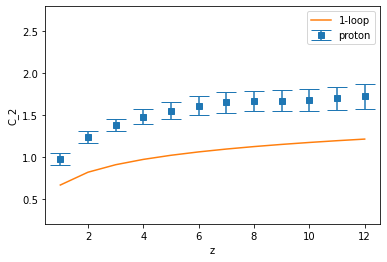

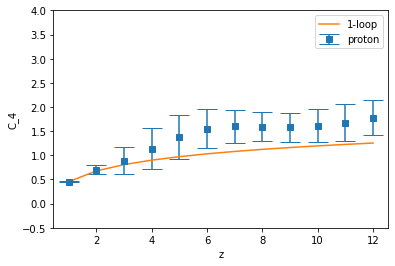

In [42]:
#################################################################################
#     Plot fitted Wilson coeffs c_2 and c_4 as a function of z
#################################################################################

def plot_cn(fitobj, n):
    av, er  = fitobj.minres['fit']
    zlst = fitobj.minres['zrange']
    av0 = np.reshape(av, (len(zlst), number_of_cn)).T[n-1]
    er0 = np.reshape(er, (len(zlst), number_of_cn)).T[n-1]
    wlst = fitobj.itdobj.cn_nlo(zlst, 2*n)
    plt.errorbar(zlst, av0, er0,  ls='', marker='s', capsize=10, label=fitobj.itdobj.hadname)
    plt.plot(zlst, wlst, label='1-loop')
    plt.xlabel('z'); plt.ylabel('C_'+str(2*n))
    
plot_cn(obj_standard, 1)
plt.ylim(0.2, 2.8)
plt.legend(); plt.show(); plt.close()

plot_cn(obj_standard, 2)
plt.ylim(-0.5, 4.0)
plt.legend(); plt.show(); plt.close()

In [43]:
######################################################################################
#     ITD moments analysis of the itd object determined by the variable "testitd"
#     The analysis is done using fitted c_n, and also using NLO c_n
#     set testitd to itd_proton if you want to analyze proton, else to itd_pion
######################################################################################

testitd = itd_pion           # change this to the hadron you want

def cn_from_fits(z, n, j):
    #
    # converts the array of fitted values of wilson coeffs into a z, n dependent function
    # j is the index that specifies which "jack-knife" value to take the c_n from
    #
    zlst = obj_standard.minres['zrange']
    cfs = np.reshape(obj_standard.resjck[j], (len(zlst), number_of_cn))
    if(n % 2 == 0 ):
        if(n == 0):
            return 1.0
        else:
            return cfs[np.int_(z) - lobj.zmin, n//2-1]
    else:
        return 0.0

# analysis object using fitted values of c_n obtained in the previous cells
testobj = itd_fit(testitd, 
                fit_nmom = number_of_cn,     # number of moments used in the OPE for the fit
                fit_type =  'fit_moments',   # analysis type. Fit the moments in this case
                wilson_input = cn_from_fits, # the input wilson coefficient function
                kernel_type = 'sample'       # wilson coeff function fluctuates with config or not. 'sample'=fluctuates
               )
# analysis object using NLO c_n
testobj_nlo = itd_fit(testitd, 
                fit_nmom = number_of_cn, 
                fit_type =  'fit_moments',
                kernel_type = 'nlo'         # NLO wilson coeff
               )

print('initialized ITD that has to be analyzed using NLO and new kernel')

# do some fits; not much to see below than some ugly code
mdat2 = np.zeros((lobj.zmax-lobj.zmin, 3))
mdat4 = np.zeros((lobj.zmax-lobj.zmin, 3))

mdat2_nlo = np.zeros((lobj.zmax-lobj.zmin, 3))
mdat4_nlo = np.zeros((lobj.zmax-lobj.zmin, 3))

j=0
for z in range(lobj.zmin, lobj.zmax):
    testobj.fit(fitrange = (z, z));
    testobj_nlo.fit(fitrange = (z, z));
    mdat2[j] = [ z, testobj.minres['fit'][0, 0], testobj.minres['fit'][1, 0] ]
    mdat4[j] = [ z, testobj.minres['fit'][0, 1], testobj.minres['fit'][1, 1] ]
    
    mdat2_nlo[j] = [ z, testobj_nlo.minres['fit'][0, 0], testobj_nlo.minres['fit'][1, 0] ]
    mdat4_nlo[j] = [ z, testobj_nlo.minres['fit'][0, 1], testobj_nlo.minres['fit'][1, 1] ]
    j= j+1
    
print('fits using moments as variables is now done')

initialized ITD that has to be analyzed using NLO and new kernel


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


fits using moments as variables is now done


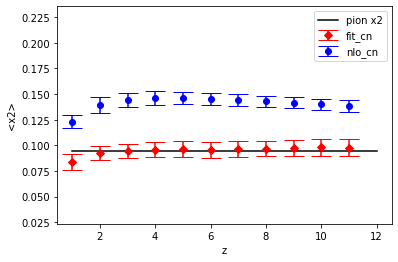

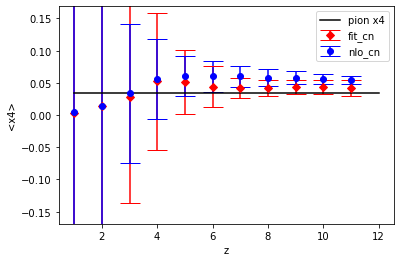

In [44]:
#################################################################################
#     Plot fitted moments <x^2> and <x^4> as a function of z.
#.    Results using fitted values of c_n (red) and NLO c_n (blue) are shown
#.    The actual value of moment for the hadron is shown by the black line
#################################################################################

plt.close()
plt.errorbar(*mdat2.T, ls='', marker = 'D', label = 'fit_cn', capsize=10, color = 'r')
plt.errorbar(*mdat2_nlo.T, ls='', marker = 'o', label = 'nlo_cn', capsize=10, color = 'b')

zaxis = obj_standard.minres['zrange']
ref = testitd.moments[2]*np.array([1.0 for z in zaxis])
plt.plot(zaxis, ref, label=testitd.hadname+' x2', color = 'black')
plt.xlabel('z'); plt.ylabel('<x2>')
plt.ylim(0.25*ref[0], 2.5*ref[0])
plt.legend(); plt.show(); plt.close()

plt.errorbar(*mdat4.T, ls='', marker = 'D', label = 'fit_cn', capsize=10, color = 'r')
plt.errorbar(*mdat4_nlo.T, ls='', marker = 'o', label = 'nlo_cn', capsize=10, color = 'b')
plt.xlabel('z'); plt.ylabel('<x4>')
ref = testitd.moments[4]*np.array([1.0 for z in zaxis])
plt.plot(zaxis, ref,  label=testitd.hadname+' x4', color = 'black')
plt.ylim(-5*ref[0], 5*ref[0])
plt.legend(); plt.show(); plt.close()

In [45]:
######################################################################################
#     PDF analysis of the itd object determined by the variable "testitd". The value of 
#      testitd is set in one of the previous cells. Change that and come here.
#
#     The ansatz used is f(x) = x^a (1-x)^b, and a,b are fitted
######################################################################################

# fit object which uses the fitted values of c_n's
jamobj = itd_fit(testitd, 
                fit_nmom = number_of_cn, 
                fit_type =  'fit_twoparams',
                wilson_input = cn_from_fits,
                kernel_type = 'sample'
               )

# NLO fit object
jamobj_nlo = itd_fit(testitd, 
                fit_nmom = 20, 
                fit_type =  'fit_twoparams',
                kernel_type = 'nlo'
               )

print('jam fitter initialized to fit ' + testitd.hadname)

# do some fits. Change "fitrange" to choose which z range to do the fits over. If error message, try 
# changing fitrange value. Not quite stable as of now, for reasons I am don't understand, but mostly works!

pars = jamobj.fit( fitrange=(1,9), verbose = True )
pars_nlo = jamobj_nlo.fit( fitrange=(1, 8), verbose = True )

print('jam fits done')

jam fitter initialized to fit pion
initial fit converged.
initial fit converged.
jam fits done


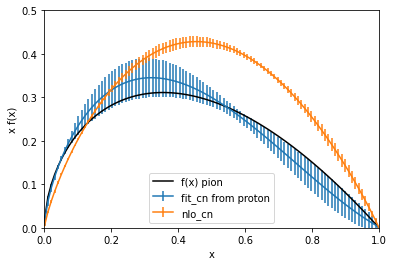

In [46]:
#################################################################################
#     Plot PDF's
#################################################################################

from scipy.special import gamma

def fv(x, a, b):
    norm = (gamma(1 + a)*gamma(1 + b))/gamma(2 + a + b)
    return x**a*(1.0-x)**b / norm

xlst = np.linspace(0.001, 1, 100)

fxinp = testitd.pdfobj.f(xlst)

plt.close()

fx = np.array([ fv(xlst, a, b) for a, b in jamobj.resjck ])
fx_nlo = np.array([ fv(xlst, a, b) for a, b in jamobj_nlo.resjck ])

av, er = np.mean(fx, axis=0), np.std(fx, axis=0)
av_nlo, er_nlo = np.mean(fx_nlo, axis=0), np.std(fx_nlo, axis=0)

plt.errorbar(xlst, av*xlst, er*xlst, label = 'fit_cn from '+obj_standard.hadname)
plt.errorbar(xlst, av_nlo*xlst, er_nlo*xlst, label = 'nlo_cn')
plt.plot(xlst, xlst*fxinp, label = 'f(x) '+testitd.hadname, color = 'black')

plt.xlabel('x'); plt.ylabel('x f(x)')
plt.xlim(0,1)
plt.ylim(0,0.5)

plt.legend()
plt.show()